In [88]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score,f1_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE

In [89]:
data=pd.read_csv('pains_removed.csv')
data.head()

,Unnamed: 0.1,Unnamed: 0,molecule_chembl_id,smiles,standard_type,standard_value,standard_units,MW,HeavyAtomMolWt,LogP,MolMR,NumHDonors,NumHAcceptors,NumAtoms,AR,TPSA,RB,bioactivity_class
0,0,0,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,33.0,nM,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0,active
1,1,1,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,314.0,nM,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0,inactive
2,2,2,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,32.0,nM,303.358,282.190,1.8677,80.3415,0.0,5.0,22.0,1.0,55.84,3.0,active
3,3,3,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,388.0,nM,303.358,282.190,1.8677,80.3415,0.0,5.0,22.0,1.0,55.84,3.0,inactive
4,4,4,CHEMBL333280,CN1CCC(O)(c2ccc(Cl)c(Cl)c2)C([C@@H](O)c2ccc(Cl...,Ki,4140.0,nM,435.178,416.026,5.1731,107.3846,2.0,3.0,26.0,2.0,43.70,3.0,inactive


In [90]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Perform label encoding
label_encoder = LabelEncoder()
data['bioactivity_class_encoded'] = label_encoder.fit_transform(data['bioactivity_class'])


<AxesSubplot: >

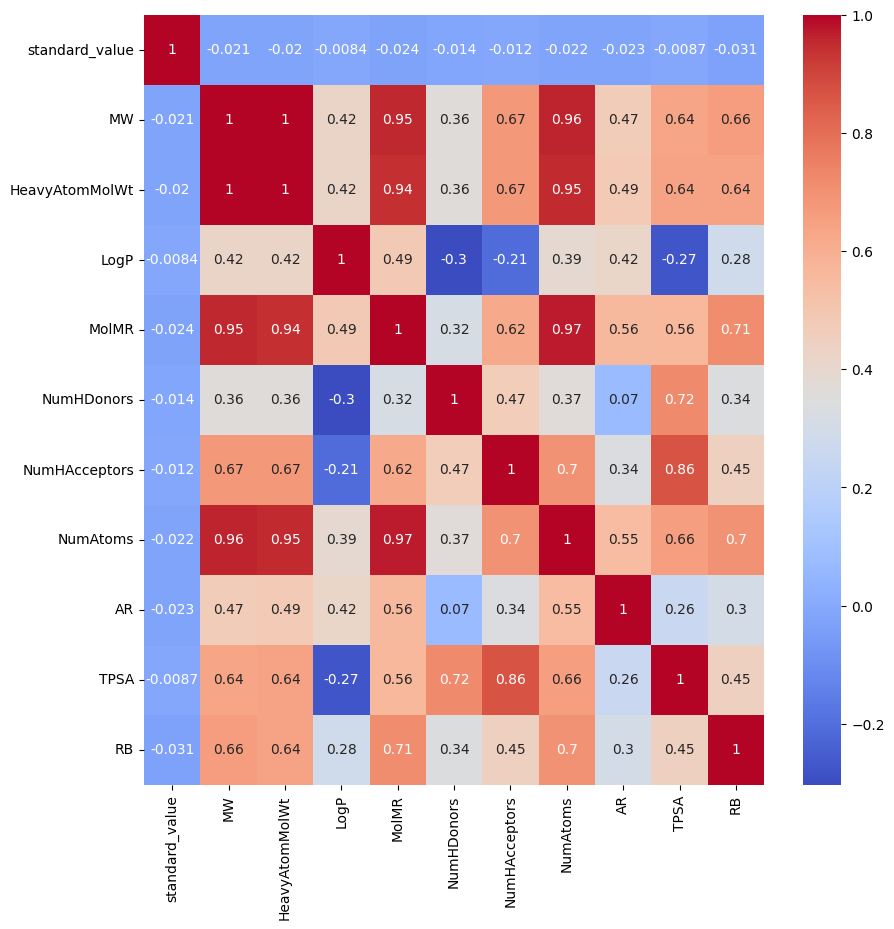

In [92]:
#Create correlation heatmap of continuous variables
import seaborn as sns

# Create a subset of the data with the relevant columns
continuous_data = data[['standard_value','MW', 'HeavyAtomMolWt', 'LogP', 'MolMR', 'NumHDonors', 'NumHAcceptors', 'NumAtoms', 'AR', 'TPSA','RB']]

# Create a correlation matrix
corr_matrix = continuous_data.corr()
plt.figure(figsize=(10, 10))
# Create a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm',annot=True)


In [93]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'molecule_chembl_id', 'smiles',
       'standard_type', 'standard_value', 'standard_units', 'MW',
       'HeavyAtomMolWt', 'LogP', 'MolMR', 'NumHDonors', 'NumHAcceptors',
       'NumAtoms', 'AR', 'TPSA', 'RB', 'bioactivity_class',
       'bioactivity_class_encoded'],
      dtype='object')

In [94]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def compute_vif(considered_features):
    
    X = data[considered_features]
    X['intercept'] = 1
   
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

considered_features = ['standard_value', 'MW', 'HeavyAtomMolWt', 'LogP',
       'MolMR', 'NumHDonors', 'NumHAcceptors', 'NumAtoms', 'AR', 'TPSA', 'RB','bioactivity_class_encoded']
compute_vif(considered_features)


/var/folders/t0/mwd450_d17x_24_r5z4fl90m0000gn/T/ipykernel_69454/1878384054.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
0,standard_value,1.005178
1,MW,3742.444173
2,HeavyAtomMolWt,2870.813445
3,LogP,4.799974
4,MolMR,79.748216
5,NumHDonors,2.947640
6,NumHAcceptors,7.064152
7,NumAtoms,38.118445
8,AR,6.483171
9,TPSA,10.708474


In [95]:
considered_features = ['standard_value', 'MW', 'HeavyAtomMolWt', 'LogP',
       'MolMR', 'NumHDonors', 'NumHAcceptors', 'NumAtoms', 'AR', 'TPSA', 'RB','bioactivity_class_encoded']

In [96]:
X = data[considered_features]

In [97]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)
X_std_df = pd.DataFrame(X_std, columns=X.columns)
X_std_df

,standard_value,MW,HeavyAtomMolWt,LogP,MolMR,NumHDonors,NumHAcceptors,NumAtoms,AR,TPSA,RB,bioactivity_class_encoded
0,3.618378e-14,0.100314,0.103297,0.648199,0.091862,0.000000,0.071429,0.088496,0.166667,0.047748,0.06250,0.0
1,3.442942e-13,0.100314,0.103297,0.648199,0.091862,0.000000,0.071429,0.088496,0.166667,0.047748,0.06250,1.0
2,3.508730e-14,0.105028,0.109130,0.606524,0.089929,0.000000,0.119048,0.106195,0.166667,0.090260,0.09375,0.0
3,4.254335e-13,0.105028,0.109130,0.606524,0.089929,0.000000,0.119048,0.106195,0.166667,0.090260,0.09375,1.0
4,4.539420e-12,0.187366,0.200367,0.747088,0.156475,0.095238,0.071429,0.141593,0.333333,0.070637,0.09375,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5899,1.096478e-14,0.186990,0.191711,0.704044,0.179709,0.047619,0.095238,0.176991,0.333333,0.094786,0.28125,1.0
5900,4.385913e-14,0.228510,0.238399,0.705264,0.223482,0.095238,0.119048,0.212389,0.500000,0.127485,0.28125,1.0
5901,2.741195e-14,0.160303,0.168769,0.730576,0.149319,0.095238,0.095238,0.150442,0.333333,0.137167,0.21875,1.0
5902,7.861749e-14,0.167540,0.177355,0.616131,0.165259,0.047619,0.142857,0.176991,0.500000,0.121246,0.09375,1.0


In [98]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [99]:
# Separate the features (X) and the target variable (y)
X_std_df=X_std_df[considered_features]
X = X_std_df.drop('bioactivity_class_encoded', axis=1)  # Replace 'target_variable' with the name of your target variable column
y = X_std_df['bioactivity_class_encoded']

# Initialize the SelectKBest object with chi2 scoring function
k = 5  # Set the desired number of top features
selector = SelectKBest(score_func=chi2, k=k)

# Fit the selector to the data
selector.fit(X, y)

# Get the indices of the top k features
top_k_indices = selector.get_support(indices=True)

# Get the names of the top k features
top_k_features = X.columns[top_k_indices]
feature_importances = selector.scores_
# Print the top k features
print("Top", k, "Features:")
print(top_k_features.tolist())

Top 5 Features:
['standard_value', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'RB']


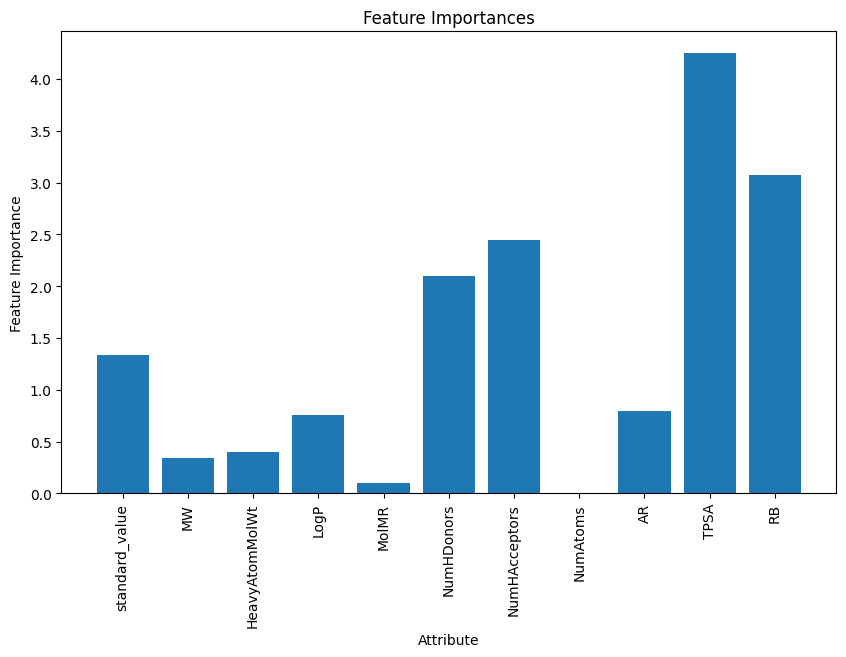

In [100]:
# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances)
plt.xlabel('Attribute')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()

In [101]:
#OLS method
import statsmodels.api as sm
X = X_std_df.drop('bioactivity_class_encoded', axis=1)  # Replace 'target_variable' with the name of your target variable column
y = X_std_df['bioactivity_class_encoded']
# Add a constant column to the features for the intercept term
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()
print(model.summary())



                                OLS Regression Results                               
Dep. Variable:     bioactivity_class_encoded   R-squared:                       0.092
Model:                                   OLS   Adj. R-squared:                  0.090
Method:                        Least Squares   F-statistic:                     53.95
Date:                       Tue, 18 Apr 2023   Prob (F-statistic):          2.80e-114
Time:                               15:26:21   Log-Likelihood:                -3379.5
No. Observations:                       5904   AIC:                             6783.
Df Residuals:                           5892   BIC:                             6863.
Df Model:                                 11                                         
Covariance Type:                   nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [69]:
#Removing MolMR, HeayAtomMolWt, NumAtoms


In [119]:
data=pd.read_csv('pains_removed.csv')
data.head()

,Unnamed: 0.1,Unnamed: 0,molecule_chembl_id,smiles,standard_type,standard_value,standard_units,MW,HeavyAtomMolWt,LogP,MolMR,NumHDonors,NumHAcceptors,NumAtoms,AR,TPSA,RB,bioactivity_class
0,0,0,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,33.0,nM,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0,active
1,1,1,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,314.0,nM,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0,inactive
2,2,2,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,32.0,nM,303.358,282.190,1.8677,80.3415,0.0,5.0,22.0,1.0,55.84,3.0,active
3,3,3,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,388.0,nM,303.358,282.190,1.8677,80.3415,0.0,5.0,22.0,1.0,55.84,3.0,inactive
4,4,4,CHEMBL333280,CN1CCC(O)(c2ccc(Cl)c(Cl)c2)C([C@@H](O)c2ccc(Cl...,Ki,4140.0,nM,435.178,416.026,5.1731,107.3846,2.0,3.0,26.0,2.0,43.70,3.0,inactive


In [118]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'molecule_chembl_id', 'smiles',
       'standard_type', 'standard_value', 'standard_units', 'MW',
       'HeavyAtomMolWt', 'LogP', 'MolMR', 'NumHDonors', 'NumHAcceptors',
       'NumAtoms', 'AR', 'TPSA', 'RB', 'bioactivity_class'],
      dtype='object')

In [120]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Perform label encoding
label_encoder = LabelEncoder()
data['bioactivity_class_encoded'] = label_encoder.fit_transform(data['bioactivity_class'])

In [116]:
data=data[['standard_value','MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'AR','RB','bioactivity_class_encoded']]
data.head()



,standard_value,MW,LogP,NumHDonors,NumHAcceptors,AR,RB,bioactivity_class_encoded
0,33.0,295.810,2.8477,0.0,3.0,1.0,2.0,0
1,314.0,295.810,2.8477,0.0,3.0,1.0,2.0,1
2,32.0,303.358,1.8677,0.0,5.0,1.0,3.0,0
3,388.0,303.358,1.8677,0.0,5.0,1.0,3.0,1
4,4140.0,435.178,5.1731,2.0,3.0,2.0,3.0,1


In [105]:
data.to_csv('clean_data2.csv')

In [121]:
data=data[['molecule_chembl_id', 'smiles',
       'standard_type', 'standard_value', 'standard_units', 'MW','LogP', 'NumHDonors', 'NumHAcceptors', 'AR', 'RB', 'bioactivity_class','bioactivity_class_encoded']]
data.head()

,molecule_chembl_id,smiles,standard_type,standard_value,standard_units,MW,LogP,NumHDonors,NumHAcceptors,AR,RB,bioactivity_class,bioactivity_class_encoded
0,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,33.0,nM,295.810,2.8477,0.0,3.0,1.0,2.0,active,0
1,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,314.0,nM,295.810,2.8477,0.0,3.0,1.0,2.0,inactive,1
2,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,32.0,nM,303.358,1.8677,0.0,5.0,1.0,3.0,active,0
3,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,388.0,nM,303.358,1.8677,0.0,5.0,1.0,3.0,inactive,1
4,CHEMBL333280,CN1CCC(O)(c2ccc(Cl)c(Cl)c2)C([C@@H](O)c2ccc(Cl...,Ki,4140.0,nM,435.178,5.1731,2.0,3.0,2.0,3.0,inactive,1


In [122]:
data.to_csv('clean_data3.csv')

<AxesSubplot: >

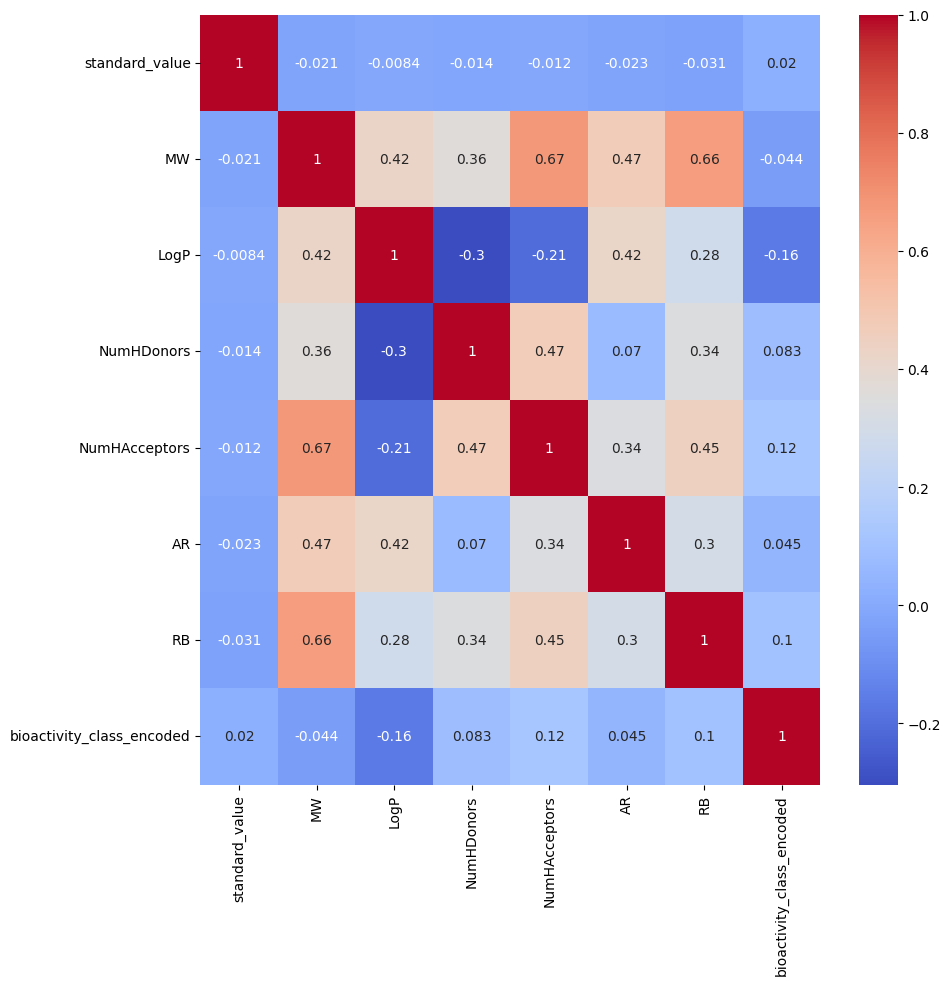

In [106]:
#Create correlation heatmap of continuous variables
import seaborn as sns

# Create a subset of the data with the relevant columns
continuous_data = data[['standard_value','MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'AR','RB','bioactivity_class_encoded']]

# Create a correlation matrix
corr_matrix = continuous_data.corr()
plt.figure(figsize=(10, 10))
# Create a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm',annot=True)


In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def compute_vif(considered_features):
    
    X = data[considered_features]
    X['intercept'] = 1
   
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

considered_features = ['standard_value','MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'AR','RB','bioactivity_class_encoded']
compute_vif(considered_features)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
0,standard_value,1.001964
1,MW,6.058545
2,LogP,4.208025
3,NumHDonors,1.719494
4,NumHAcceptors,4.746291
5,AR,1.611067
6,RB,1.900899
7,bioactivity_class_encoded,1.090125


In [108]:
X = data[considered_features]

In [109]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)
X_std_df = pd.DataFrame(X_std, columns=X.columns)
X_std_df

,standard_value,MW,LogP,NumHDonors,NumHAcceptors,AR,RB,bioactivity_class_encoded
0,3.618378e-14,0.100314,0.648199,0.000000,0.071429,0.166667,0.06250,0.0
1,3.442942e-13,0.100314,0.648199,0.000000,0.071429,0.166667,0.06250,1.0
2,3.508730e-14,0.105028,0.606524,0.000000,0.119048,0.166667,0.09375,0.0
3,4.254335e-13,0.105028,0.606524,0.000000,0.119048,0.166667,0.09375,1.0
4,4.539420e-12,0.187366,0.747088,0.095238,0.071429,0.333333,0.09375,1.0
...,...,...,...,...,...,...,...,...
5899,1.096478e-14,0.186990,0.704044,0.047619,0.095238,0.333333,0.28125,1.0
5900,4.385913e-14,0.228510,0.705264,0.095238,0.119048,0.500000,0.28125,1.0
5901,2.741195e-14,0.160303,0.730576,0.095238,0.095238,0.333333,0.21875,1.0
5902,7.861749e-14,0.167540,0.616131,0.047619,0.142857,0.500000,0.09375,1.0


In [110]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [111]:
# Separate the features (X) and the target variable (y)
X_std_df=X_std_df[considered_features]
X = X_std_df.drop('bioactivity_class_encoded', axis=1)  # Replace 'target_variable' with the name of your target variable column
y = X_std_df['bioactivity_class_encoded']

# Initialize the SelectKBest object with chi2 scoring function
k = 5  # Set the desired number of top features
selector = SelectKBest(score_func=chi2, k=k)

# Fit the selector to the data
selector.fit(X, y)

# Get the indices of the top k features
top_k_indices = selector.get_support(indices=True)

# Get the names of the top k features
top_k_features = X.columns[top_k_indices]
feature_importances = selector.scores_
# Print the top k features
print("Top", k, "Features:")
print(top_k_features.tolist())

Top 5 Features:
['standard_value', 'NumHDonors', 'NumHAcceptors', 'AR', 'RB']


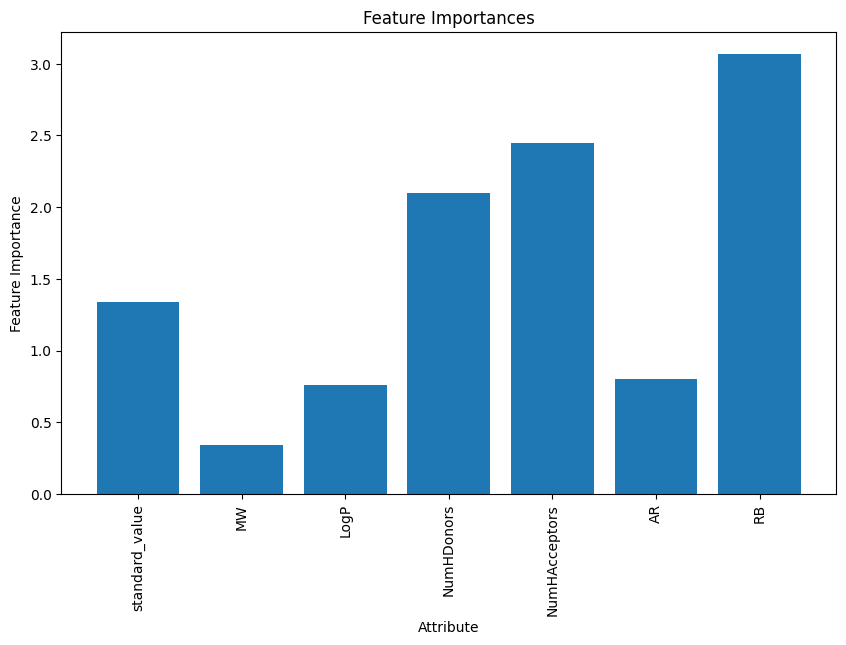

In [112]:
# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances)
plt.xlabel('Attribute')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()

In [113]:
#OLS method
import statsmodels.api as sm
X = X_std_df.drop('bioactivity_class_encoded', axis=1)  # Replace 'target_variable' with the name of your target variable column
y = X_std_df['bioactivity_class_encoded']
# Add a constant column to the features for the intercept term
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()
print(model.summary())



                                OLS Regression Results                               
Dep. Variable:     bioactivity_class_encoded   R-squared:                       0.083
Model:                                   OLS   Adj. R-squared:                  0.082
Method:                        Least Squares   F-statistic:                     75.91
Date:                       Tue, 18 Apr 2023   Prob (F-statistic):          9.33e-106
Time:                               15:26:59   Log-Likelihood:                -3408.0
No. Observations:                       5904   AIC:                             6832.
Df Residuals:                           5896   BIC:                             6885.
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------